<a href="https://colab.research.google.com/github/americanthinker/rag-applications/blob/main/notebooks/4-Reranking_Week2.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Week 2: Building Advanced RAG Applications.  Authored by Chris Sanchez.

# Week 2 - Notebook 4

# Overview

Welcome to Week 2 of the course!  We covered a lot of content last week in order to get to the point where we can search over our data.  In this notebook, you'll have the chance to improve your baseline retrieval scores by combining the strengths of keyword and vector search using Weaviate's `hybrid_search` method.  We'll also incorporate the use of a CrossEncoder reranker to pack the final punch in our retrieved hits, before we pass those results to the LLM for answer synthesis.  Here's a reminder of where we've been and where we're going:

#### Week One
* ~Part 1:~
  * ~Data ingest and preprocessing~
  * ~Convert text into vectors~
* ~Part 2~:
  * ~Index data on Weaviate database~
  * ~Search over data~
* ~Part 2.5~:
  * ~Benchmark retrieval results~

#### Week Two
* **Part 4 (THIS NOTEBOOK)**:
  * **Add Hybrid Search and ReRanker to the mix (new benchmark)**
* Part 5:
  * LLM Integration

#### This notebook will cover the highlighted portion of the technical diagram below, as initially referenced in the Course content:

![arch diagram]( 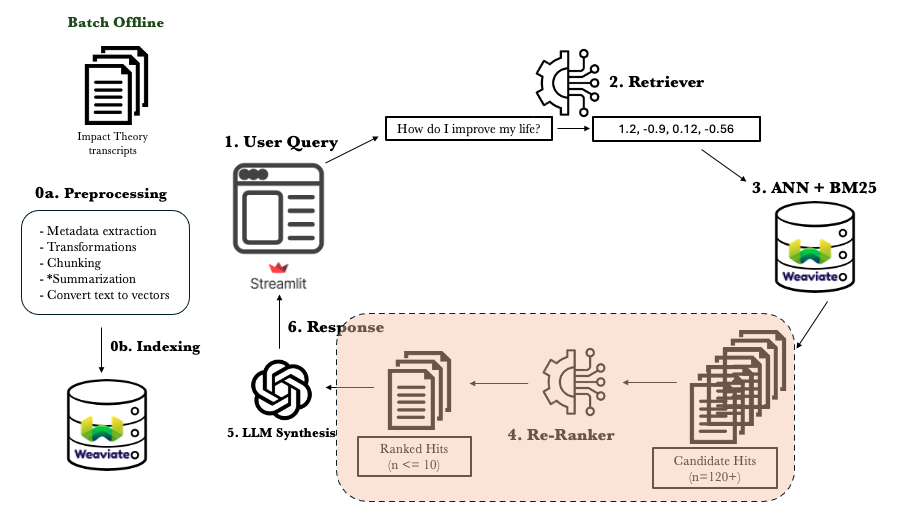)

## If running in Colab, uncomment cells below!

In [1]:
!pip install tqdm --quiet
!pip install rich --quiet
!pip install python-dotenv --quiet
!pip install loguru --quiet
!pip install tiktoken --quiet
!pip install litellm --quiet
!pip install instructor --quiet
!pip install weaviate-client --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.8/223.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 17.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

In [2]:
!mkdir src
!mkdir src/preprocessor
!mkdir src/database
!mkdir src/evaluation
!mkdir src/llm
!mkdir data
!mkdir data/golden_datasets

In [3]:
!curl -o src/preprocessor/preprocessing.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/preprocessor/preprocessing.py
!curl -o src/database/weaviate_interface_v4.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/database/weaviate_interface_v4.py
!curl -o src/reranker.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/reranker.py
!curl -o src/evaluation/eval_prompt_templates.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/evaluation/eval_prompt_templates.py
!curl -o src/llm/llm_utils.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/llm/llm_utils.py
!curl -o src/llm/llm_interface.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/llm/llm_interface.py
!curl -o src/llm/prompt_templates.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/llm/prompt_templates.py
!curl -o src/evaluation/retrieval_evaluation.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/evaluation/retrieval_evaluation.py
!curl -o src/data_models.py https://raw.githubusercontent.com/americanthinker/rag-applications/main/src/data_models.py
!curl -o data/golden_datasets/golden_256.json https://raw.githubusercontent.com/americanthinker/rag-applications/main/data/golden_datasets/golden_256.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5501  100  5501    0     0  19734      0 --:--:-- --:--:-- --:--:-- 19716
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21404  100 21404    0     0  83578      0 --:--:-- --:--:-- --:--:-- 83937
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3700  100  3700    0     0  15425      0 --:--:-- --:--:-- --:--:-- 15481
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9465  100  9465    0     0  31980      0 --:--:-- --:--:-- --:--:-- 32084
  % Total    % Received % Xferd  Average Speed   Tim

In [4]:
import sys
sys.path.append('../')

#load from local .env file
from dotenv import load_dotenv, find_dotenv
env = load_dotenv(find_dotenv(), override=True)

#standard python
import os

# external libraries
from tqdm import tqdm
from rich import print  # nice library that provides improved printing output (overrides default print function)

# external files
from src.reranker import ReRanker
from src.database.weaviate_interface_v4 import WeaviateWCS

## Setup
***

### Instaniate Weaviate Client

In [5]:
#read env vars from local .env file
#api_key = os.environ['WEAVIATE_API_KEY']
from google.colab import userdata

api_key = userdata.get('WEAVIATE_API_KEY')

#url = os.environ['WEAVIATE_ENDPOINT']
url = userdata.get('WEAVIATE_ENDPOINT')

#instantiate client
client = WeaviateWCS(url, api_key)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
#display available collection names on cluster
client.show_all_collections()

['Huberman_minilmL6_256']

### Set Collection name

In [7]:
#set collection name to run queries on
collection_name = client.show_all_collections()[0]

## Discussion  

Hybrid search does just what it sounds like: it combines a keyword search with a vector search, which has the effect of combining the strengths of each method for improved retrieval.  If you'll recall, the initial vector retrieval results we saw with our out-of-the-box `miniLM` model were about 10 percentage points lower compared to the keyword results. My initial results with the `chunk_size` 256 dataset were:

```
{'n': 5,
 'Retriever': 'sentence-transformers/all-MiniLM-L6-v2',
 'chunk_size': 256,
 'query_props': ['content'],
 'kw_hit_rate': 0.78,
 'kw_mrr': 0.64,
 'vector_hit_rate': 0.68,
 'vector_mrr': 0.56,
 'total_misses': 16,
 'total_questions': 100
}
```
You may also have noticed that the `total_misses` score was `16`, meaning that neither search method picked up the golden `doc_id` in the "n" retrieved results, a total of 16 times.  From another perspective, it means that between keyword and vector search, they found 84 out of 100 of the golden `doc_ids`.  So if 84 docs were found then how come we don't see a hit rate score of 84 in one of the two methods....?

If you compare the total misses with the keyword hit rate (the highest scoring method), you'll see that keyword picked up 78 of the correct docs, but that 84 docs were found between the two methods.  We can interpret this to mean that the vector search method accounts for the difference of 6 hits between the keyword hit rate and the total of 84 correct documents found.  Combining these two search methods through hybrid search allows us to close this gap.

# Hybrid Search - `RelativeRankFusion`  
If you recall from the [Course Notes](https://weaviate.io/blog/hybrid-search-fusion-algorithms), Weaviate's Hybrid search method uses the `RelativeRankFusion` algorithm under the hood. Combining keyword and vector search scores is an area of active research, so the algorithm used by Weaviate is "a" way to perform hybrid search, not "the" way.  

**Let's walk through the steps at a high level and then break it down in code:**
1. Execute a keyword and a vector search and get the raw scores and doc_ids of each.
2. Normalize scores between 0 and 1 relative to each method.
3. Multiply the normalized scores by a weighted value: `alpha`.
4. Add scores together that both have the same `doc_id`.
5. Combine search results together in ranked order according to score values.

### Get responses to query

In [8]:
query = 'Why is sleep so important to maximizing healthspan'

In [9]:
kw_response = client.keyword_search(query, collection_name, limit=10)
vector_response = client.vector_search(query, collection_name, limit=10)


### Extract scores and doc_ids

In [10]:
from collections import OrderedDict, defaultdict

def get_scores_ids(response: list[dict], include_cross_score: bool=False, limit: int=10):
    '''
    Extracts scores and ids from response object.
    If keyword, extracts from "score" field.
    If vector, extracts from "distance" field and
    subtracts from 1 in keeping with the concept that
    higher scores are better.
    '''
    def round_(score: str, place: int=3):
        return round(float(score),place)

    score_dict = OrderedDict()
    if response[0].get('score'):
        if include_cross_score:
            return {d['doc_id'] : f'Score: {round_(d["score"])}   :   Cross-Score: {round_(d["cross_score"])}' for d in response[:limit]}
        return {d['doc_id'] : round_(d['score'], 3) for d in response[:limit]}
    return {d['doc_id'] : round_(1 - d['distance'],3) for d in response[:limit]}

### Raw scores
Using the above function we're going to pull out the `doc_ids` and the raw (unnormalized) scores from each search method. Note the difference in score magnitude between BM25 ranking and the Cosine score.

In [11]:
raw_kw_scores = get_scores_ids(kw_response)
raw_vec_scores = get_scores_ids(vector_response)
raw_kw_scores, raw_vec_scores

({'ufsIA5NARIo_1': 8.558,
  'ufsIA5NARIo_8': 5.824,
  'oNkDA2F7CjM_52': 5.348,
  'DTCmprPCDqc_2': 5.305,
  'q1Ss8sTbFBY_0': 5.112,
  'O1YRwWmue4Y_3': 5.088,
  'q37ARYnRDGc_132': 4.871,
  'oNkDA2F7CjM_69': 4.853,
  'ufsIA5NARIo_0': 4.765,
  'VQLU7gpk_X8_95': 4.699},
 {'iw97uvIge7c_82': 0.627,
  '-OBCwiPPfEU_87': 0.62,
  'h2aWYjSA1Jc_1': 0.619,
  'yb5zpo5WDG4_16': 0.613,
  'LTGGyQS1fZE_38': 0.597,
  'gbQFSMayJxk_133': 0.594,
  'tLS6t3FVOTI_40': 0.575,
  'FFwA0QFmpQ4_47': 0.573,
  'h2aWYjSA1Jc_100': 0.572,
  'h2aWYjSA1Jc_103': 0.566})

### Normalize scores relative to each method
Normalize all scores so that the values are between 0 and 1 relative to one other **within** each method.  In other words we are normalizing scores for each method, not normalizing across all scores, because this will not work in practice given that a BM25 score has no meaning relative to a Cosine Similarity score.  

In [12]:
#using sklearn to normalize scores
from sklearn.preprocessing import MinMaxScaler
from numpy import ndarray

scaler = MinMaxScaler()
kw_normal = scaler.fit_transform([[score] for score in raw_kw_scores.values()])
vec_normal = scaler.fit_transform([[score] for score in raw_vec_scores.values()])
kw_normal, vec_normal

(array([[1.        ],
        [0.2915263 ],
        [0.16817828],
        [0.1570355 ],
        [0.10702254],
        [0.10080332],
        [0.04457113],
        [0.03990671],
        [0.01710288],
        [0.        ]]),
 array([[1.        ],
        [0.8852459 ],
        [0.86885246],
        [0.7704918 ],
        [0.50819672],
        [0.45901639],
        [0.14754098],
        [0.1147541 ],
        [0.09836066],
        [0.        ]]))

### Multiply by weighted alpha value

Weight the values by multiplying by the `alpha` parameter. `alpha` is an indication of how strong we want to weight the scores toward vector search.  Setting `alpha` to 0 results in a pure keyword search (vector scores will be multiplied by 0, meaning they won't be considered as part of the search results) and setting `alpha` to 1 results in a pure vector-based search. For this example we'll set `alpha` to `0.45` meaning we'll multiply the vector scores by `0.45` (thus diminishing their importance to the returned results) and multiply the keyword scores by `0.55` (boosting their importance to the returned results).  

In [13]:
alpha = 0.45
kw_weighted = kw_normal * (1 - alpha)
vec_weighted = vec_normal * alpha
kw_weighted, vec_weighted

(array([[0.55      ],
        [0.16033947],
        [0.09249806],
        [0.08636953],
        [0.0588624 ],
        [0.05544182],
        [0.02451412],
        [0.02194869],
        [0.00940658],
        [0.        ]]),
 array([[0.45      ],
        [0.39836066],
        [0.39098361],
        [0.34672131],
        [0.22868852],
        [0.20655738],
        [0.06639344],
        [0.05163934],
        [0.0442623 ],
        [0.        ]]))

### Update final scores

After intra-method normalization and score weighting, we can now update our docs with their new scores.  One more step to complete is to add together any scores coming from the same document in both results.  This should make intuitive sense, we want to boost the scores of documents that **both** methods picked up.  

In [14]:
def update_scores(weighted_kw_scores: ndarray,
                  weighted_vec_scores: ndarray
                 ) -> None:
    updated_kw_scores = {}
    updated_vec_scores = {}
    for i, k in enumerate(raw_kw_scores):
        updated_kw_scores[k] = weighted_kw_scores[i][0]
    for i, k in enumerate(raw_vec_scores):
        updated_vec_scores[k] = weighted_vec_scores[i][0]
    return updated_kw_scores, updated_vec_scores

In [15]:
updated_kw_scores, updated_vec_scores = update_scores(kw_weighted, vec_weighted)

#the updated scores should look very different from their original raw scores
print(updated_kw_scores, updated_vec_scores)

{
    'ufsIA5NARIo_1': 0.5499999999999999,
    'ufsIA5NARIo_8': 0.16033946618294886,
    'oNkDA2F7CjM_52': 0.092498056491319,
    'DTCmprPCDqc_2': 0.08636952578388178,
    'q1Ss8sTbFBY_0': 0.058862399585384785,
    'O1YRwWmue4Y_3': 0.055441824306815185,
    'q37ARYnRDGc_132': 0.02451412282974871,
    'oNkDA2F7CjM_69': 0.021948691370821383,
    'ufsIA5NARIo_0': 0.00940658201606629,
    'VQLU7gpk_X8_95': 0.0
}
{
    'iw97uvIge7c_82': 0.44999999999999923,
    '-OBCwiPPfEU_87': 0.3983606557377048,
    'h2aWYjSA1Jc_1': 0.390983606557377,
    'yb5zpo5WDG4_16': 0.3467213114754095,
    'LTGGyQS1fZE_38': 0.2286885245901635,
    'gbQFSMayJxk_133': 0.20655737704918017,
    'tLS6t3FVOTI_40': 0.0663934426229508,
    'FFwA0QFmpQ4_47': 0.05163934426229444,
    'h2aWYjSA1Jc_100': 0.04426229508196666,
    'h2aWYjSA1Jc_103': 0.0
}

### Review top hits from each method  
Pause at this point to look at the top couple of hits of each search method to gain a better understanding of how these hits are being ranked by each search method.  You'll note here, assuming you executed this query `Why is sleep so important to maximizing healthspan` that the top hits for each method are not only different, they are also unique across the top 10 results for each. This point is important because it indicates that while the general meaning between the two search results may be simliar, the actual content can be very different, hence the need for a hybrid method that combines the best of both worlds.

In [16]:
def review_top_n_hits(updated_kw_scores: dict, updated_vec_scores: dict, top_n: int=2, return_hits: bool=False):
    """Filters and prints top-n hits from search results"""
    kw_top_scores = sorted(updated_kw_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    vec_top_scores = sorted(updated_vec_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    kw_hits = [hit[0] for hit in kw_top_scores]
    vec_hits = [hit[0] for hit in vec_top_scores]
    for i, hit in enumerate(kw_hits, 1):
        content = [response['content'] for response in kw_response if response['doc_id'] == hit][0]
        print(f'KEYWORD RESPONSE: {i}\n{content}')
    for i, hit in enumerate(vec_hits, 1):
        content = [response['content'] for response in vector_response if response['doc_id'] == hit][0]
        print(f'VECTOR RESPONSE: {i}\n{content}')
    if return_hits:
        return kw_hits, vec_hits

In [17]:
review_top_n_hits(updated_kw_scores, updated_vec_scores)

KEYWORD RESPONSE: 1
He explains the behavioral, nutritional, supplementation-based, and prescription drug-based approaches that one can
use in order to extend healthspan and longevity. Dr. Atiyah explains the key tests and markers that we should all 
pay attention to if our goal is to extend our healthspan and how to do so while maximizing our vitality. This is 
something that not a lot of people think about when they think about healthspan and longevity, but as Dr. Atiyah 
illustrates for us, emotional health has everything to do with our physical health and vice versa. And he shares 
quite openly about his own experiences in pursuing ways to improve emotional health and thereby healthspan, 
lifespan, and vitality. Dr. Atiyah is quite open about his own experiences, exploring different practices to 
improve emotional health as ways not just to improve healthspan longevity and vitality, but of course also to 
derive the most meaning and satisfaction from life. Throughout today's discussion, we also discussed Dr. Atiyah's 
newly released book, which is entitled Outlive, The Science and Art of Longevity. This is a phenomenal book. I've 
read it cover to cover now three times. I have extensive notes written throughout.

KEYWORD RESPONSE: 2
It is binary. You are alive or you are not alive. And clearly part of longevity is about how long you live. Now, I 
think for a lot of people, that tends to be where the discussion ends. That tends to be the focus of it, right? 
It's sort of like, you know, longevity somehow implies living for, you know, 100 years, 120 years, something like 
to that extent. We talk a lot about maximum lifespan. Even in laboratory experiments with mice, that's sort of one 
of the metrics that's discussed is what's maximal lifespan of the animals. But there's an equally, if not slightly,
I think potentially more important part of longevity, which is healthspan. And healthspan is squishier and I think 
it requires some definition. Now the medical definition of healthspan is the period of time by which you are free 
from disability and disease. I find that to be a not particularly helpful definition because by that definition you
and I have the same health span today that we did 30 years ago. But I know you pretty well, you know me pretty 
well.

VECTOR RESPONSE: 1
It is the bedrock of mental health, physical health, and performance. Sleep and the power of sleep far exceeds any 
nootropic you could ever take, any prescription drug you could ever take, any health-promoting tool for your immune
system, your metabolism, your mental function, your physical function you could ever take. Sleep is the bedrock. I 
know a lot of people experience challenge with sleep. Nobody is perfect about sleep. That's important to keep in 
mind. I think a good goal is to get enough quality sleep of sufficient duration, 80% of the nights of your life, 
and then as much as possible to make sure that the remaining 20% of nights, you're not getting enough sleep for 
good reasons as opposed to hard reasons. Good reasons would include raising children. That's important. After all, 
every species desires to make more of itself and to preserve and extend the wellbeing of its young.

VECTOR RESPONSE: 2
Well, I can do it with the stick and I can do the whole sort of, you know, if it bleeds, it leads and do the 
doomsday stuff and that can motivate. But why don't I try to understand what it would be for most people that would
have them try to enact better sleep behaviors? And they asked all sorts of different options. And the two things at
the end of the paper, when they did all the statistics that stood out like two sore thumbs, I want to try to 
improve my sleep because I want to improve my mood. I want to improve my sleep because I want to improve my body 
weight. People know it. They already knew it. We didn't have to show them the data. And so it's just interesting. 
So I'm just bringing those two things up as carrot examples. There are many others, of course, too. Terrific 
examples of carrots that one can get if they get adequate sleep. And we'll talk about quality and some other 
features of sleep that are important in just a moment. But I'm curious, how come when we are sleep deprived, we get
bags under our eyes and our skin health shows it?

### Add together any documents with the same doc_id and then sort final results

In [18]:
def add_doc_scores(updated_kw_scores: dict[str, float],
                   updated_vec_scores: dict[str, float],
                   top_k: int=5
                  ) -> list[tuple[str, float]]:
    '''
    Combined keyword and vector scores by adding values
    for any duplicate docs and then sorts resulting
    dictionary of results.  Returns top_k values.
    '''
    hybrid_results = updated_kw_scores
    for k,value in updated_vec_scores.items():
        if k in updated_kw_scores:
            hybrid_results[k] += value
        else:
            hybrid_results[k] = value
    print(hybrid_results)
    return sorted(hybrid_results.items(), key=lambda x: x[1], reverse=True)[:top_k]

In [19]:
# #compare these final ranked value with the original keyword and vector queries
ranked_results = add_doc_scores(updated_kw_scores, updated_vec_scores, top_k=5)
ranked_results

{
    'ufsIA5NARIo_1': 0.5499999999999999,
    'ufsIA5NARIo_8': 0.16033946618294886,
    'oNkDA2F7CjM_52': 0.092498056491319,
    'DTCmprPCDqc_2': 0.08636952578388178,
    'q1Ss8sTbFBY_0': 0.058862399585384785,
    'O1YRwWmue4Y_3': 0.055441824306815185,
    'q37ARYnRDGc_132': 0.02451412282974871,
    'oNkDA2F7CjM_69': 0.021948691370821383,
    'ufsIA5NARIo_0': 0.00940658201606629,
    'VQLU7gpk_X8_95': 0.0,
    'iw97uvIge7c_82': 0.44999999999999923,
    '-OBCwiPPfEU_87': 0.3983606557377048,
    'h2aWYjSA1Jc_1': 0.390983606557377,
    'yb5zpo5WDG4_16': 0.3467213114754095,
    'LTGGyQS1fZE_38': 0.2286885245901635,
    'gbQFSMayJxk_133': 0.20655737704918017,
    'tLS6t3FVOTI_40': 0.0663934426229508,
    'FFwA0QFmpQ4_47': 0.05163934426229444,
    'h2aWYjSA1Jc_100': 0.04426229508196666,
    'h2aWYjSA1Jc_103': 0.0
}

[('ufsIA5NARIo_1', 0.5499999999999999),
 ('iw97uvIge7c_82', 0.44999999999999923),
 ('-OBCwiPPfEU_87', 0.3983606557377048),
 ('h2aWYjSA1Jc_1', 0.390983606557377),
 ('yb5zpo5WDG4_16', 0.3467213114754095)]

### Compare manually generated scores with Weaviate hybrid method

In [20]:
#scores and ranking are slightly off due to the way that keyword results are processed

hyb_response = client.hybrid_search(query, collection_name, alpha=alpha, limit=5)
get_scores_ids(hyb_response), ranked_results

({'ufsIA5NARIo_1': 0.55,
  '-OBCwiPPfEU_87': 0.477,
  'iw97uvIge7c_82': 0.454,
  'h2aWYjSA1Jc_1': 0.422,
  'yb5zpo5WDG4_16': 0.401},
 [('ufsIA5NARIo_1', 0.5499999999999999),
  ('iw97uvIge7c_82', 0.44999999999999923),
  ('-OBCwiPPfEU_87', 0.3983606557377048),
  ('h2aWYjSA1Jc_1', 0.390983606557377),
  ('yb5zpo5WDG4_16', 0.3467213114754095)])

# Assignment 2.1 - Compare Search Methods
***
**Submit queries using the various search methods and observe how the results, and their ordering, changes.**

#### Instructions:
- Run the print statements and observe how the results change (or don't) based on the search method.
- Play around with the `alpha_value` parameter and notice how the hybrid search results match the other search methods depending on how close to zero or one the value is.
- Once you have a comfortable understanding of how hybrid search compares to the other methods, move on to Reranking.

In [21]:
def print_results_by_key(results: list[dict], return_props: list[str]) -> None:
    '''
    Pretty-prints nested search results
    '''
    from rich.pretty import pprint
    keys = return_props + ['score', 'distance']
    for r in results:
        for key in r:
            if key in keys:
                pprint(f'{key.upper()}: {r[key]}')
        print('\n\n')
    print('-'*100)

In [22]:
def print_results(client: WeaviateWCS,
                  collection_name: str,
                  queries: list[str],
                  return_props: list[str],
                  alpha_value: float
                  ) -> None:
    '''
    Prints search results grouped by search method
    '''
    for q in queries:
        kw_result = client.keyword_search(q, collection_name, return_properties=return_props, limit=3)
        vector_result = client.vector_search(q, collection_name, return_properties=return_props, limit=3)
        hybrid_result = client.hybrid_search(q, collection_name, return_properties=return_props, alpha=alpha_value, limit=3)
        print('*'*100)
        print(f'QUERY: {q}')
        print(f'KEYWORD RESULTS:')
        print_results_by_key(kw_result, return_props)
        print(f'VECTOR RESULTS:')
        print_results_by_key(vector_result, return_props)
        print(f'HYBRID RESULTS:')
        print_results_by_key(hybrid_result, return_props)

In [23]:
queries = ['How to fight age-related muscle loss', 'Ways to increase dopamin naturally', 'What is the role of the mid-singulate cortex in the human brain']
return_props = ['title', 'content', 'doc_id']
alpha_value = 0.2

print_results(client, collection_name, queries, return_props, alpha_value)

****************************************************************************************************

QUERY: How to fight age-related muscle loss

KEYWORD RESULTS:

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

"CONTENT: In general, human movement is a function of, number one, some sort of neuromuscular activation. So nerves have to turn on. The second part is muscles have to contract. And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's true. However, what they don't realize is you lose about 2% to 4% of your strength per year. So the loss of strength is almost double that, the loss of muscle mass with aging. Muscle power is more like 8% to 10% per year."

'DOC_ID: CyDLbrZK75U_4'

'SCORE: 8.990565299987793'

"CONTENT: As well, I talked about how some people are supplementing with lutein even though they don't have age-related macular degeneration with the idea in mind that it might help offset some vision loss as they get older. I said lutein, and lutein was the correct thing to say, but once or twice when I started speaking fast, I said leucine and not lutein. I want to emphasize that leucine and amino acid, very interesting, important for muscle building, covered in previous episodes, but lutein, L-U-T-E-I-N, is the molecule and compound that I was referring to in terms of supplementing for sake of vision. So I apologize, please forgive me, I misspoke. A couple of you caught that right away in listening to the episode after it went up, I realized that I'd misspoken. So lutein for vision, leucine for muscles and muscle growth and strength, et cetera. Before we dive into the content of today's episode, I want to just briefly touch on color vision. Many of you asked questions about color vision and color perception. And indeed, color perception is a fascinating aspect of the human visual system."

'TITLE: How Smell, Taste & Pheromone-Like Chemicals Control You'

'DOC_ID: Mwz8JprPeMc_11'

'SCORE: 6.721503734588623'

'TITLE: Healthy Eating & Eating Disorders - Anorexia, Bulimia, Binging | Huberman Lab Podcast #36'

"CONTENT: So they don't have them weight training. They weren't doing curls and dips and squats and things of that sort. They were moving their own body weight, but they skewed that distribution of body weight by restricting a limb and forcing them to use one limb that did indeed grow in response to that. And then in humans, there was an exploration of grip strength. And then with resistance training, that was also carried out through a peripheral study. Basically the takeaway from this study was that mice and humans can utilize amino acids that are ingested early in the day better than they can utilize amino acids ingested later in the day, in particular toward muscle hypertrophy and growth or maintenance of muscle, which for those of you that aren't interested in muscle hypertrophy, that aren't trying to grow your muscles, I've talked before in the episode on building strength and hypertrophy, that maintaining muscle, regardless of one's athletic prowess, regardless of one's age, is extremely important because loss of skeletal muscle is one of the major causes of injury as we age. It's one of the major causes, believe it or not, of cognitive and metabolic deficits as we age. So maintaining muscle is important."

'DOC_ID: 2XGREPnlI8U_10'

'SCORE: 6.674013614654541'

----------------------------------------------------------------------------------------------------

VECTOR RESULTS:

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

"CONTENT: In general, human movement is a function of, number one, some sort of neuromuscular activation. So nerves have to turn on. The second part is muscles have to contract. And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's true. However, what they don't realize is you lose about 2% to 4% of your strength per year. So the loss of strength is almost double that, the loss of muscle mass with aging. Muscle power is more like 8% to 10% per year."

'DOC_ID: CyDLbrZK75U_4'

'DISTANCE: 0.3511979579925537'

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

"CONTENT: In fact, there's actually interesting data that just came out showing this reduction in muscle strength and hypertrophy that I sort of talked about is basically ameliorated with a preservation of activity. In other words, you don't lose these functionalities because of aging. You lose these because of a loss of training. To state that again, you don't lose these because of some innate physiological thing that happens with genes become less sensitive or you lose functionality. You pretty much can describe the loss of function of strength and muscle in aging as exclusively because of a loss of training and nutrition and anabolic resistance and some other things. So you can do a lot more than you think when it comes to maintaining high quality muscle. And that's really important to point out. I'm reminded of the words of the great Sherrington. He won the Nobel prize as a physiologist. I guess the neuroscientists try and claim him as a neuroscientist because he worked on the nervous system. The physiologists claim as a, as a physiologist. He is 100% a physiologist. I would call him a neuroscientist. Maybe we can argue about this later. We will."

'DOC_ID: CyDLbrZK75U_8'

'DISTANCE: 0.35205668210983276'

'TITLE: Science of Muscle Growth, Increasing Strength & Muscular Recovery'

"CONTENT: But I think the research shows now that everyone of pretty much every age should be doing some sort of resistance exercise, even if that's body weight exercises in order to offset this age-related decline in muscle contractile ability, muscle strength, et cetera, improve bone density. There's nothing good about getting frail and weak over time. And people who invest the effort into doing resistance exercise of some kind, whether or not it's with bands or with weights or with body weight, really benefit tremendously at a whole body level, at a systemic level, as well as in terms of muscle strength. There is a good predictor of how well or how efficient you will be in building the strength and or if you like the size of a given muscle. And it has everything to do with those upper motor neurons that are involved in deliberate control of muscle. You can actually do this test right now. You can just kind of march across your body mentally and see whether or not you can independently contract any or all of your muscles."

'DOC_ID: XLr2RKoD-oY_40'

'DISTANCE: 0.3656594157218933'

----------------------------------------------------------------------------------------------------

HYBRID RESULTS:

'TITLE: Dr. Andy Galpin: Optimal Protocols to Build Strength & Grow Muscles | Huberman Lab Guest Series'

"CONTENT: In general, human movement is a function of, number one, some sort of neuromuscular activation. So nerves have to turn on. The second part is muscles have to contract. And the third part is those muscles have to move a bone. All right. If you want to be alive and you want to live by yourself, you have to be able to engage in human movement. If you have any dysfunction in the neuromuscular system there, then you're not going to be able to do that. And again, as I mentioned, the only way to preserve that or fight that loss of aging is to strength train. So people will tend to hear numbers like you lose about 1% of muscle size per year after age about 40. And that's true. However, what they don't realize is you lose about 2% to 4% of your strength per year. So the loss of strength is almost double that, the loss of muscle mass with aging. Muscle power is more like 8% to 10% per year."

'DOC_ID: CyDLbrZK75U_4'

'SCORE: 1.0'

"CONTENT: But I think the research shows now that everyone of pretty much every age should be doing some sort of resistance exercise, even if that's body weight exercises in order to offset this age-related decline in muscle contractile ability, muscle strength, et cetera, improve bone density. There's nothing good about getting frail and weak over time. And people who invest the effort into doing resistance exercise of some kind, whether or not it's with bands or with weights or with body weight, really benefit tremendously at a whole body level, at a systemic level, as well as in terms of muscle strength. There is a good predictor of how well or how efficient you will be in building the strength and or if you like the size of a given muscle. And it has everything to do with those upper motor neurons that are involved in deliberate control of muscle. You can actually do this test right now. You can just kind of march across your body mentally and see whether or not you can independently contract any or all of your muscles."

'TITLE: Science of Muscle Growth, Increasing Strength & Muscular Recovery'

'DOC_ID: XLr2RKoD-oY_40'

'SCORE: 0.6151092648506165'

'TITLE: Healthy Eating & Eating Disorders - Anorexia, Bulimia, Binging | Huberman Lab Podcast #36'

"CONTENT: So they don't have them weight training. They weren't doing curls and dips and squats and things of that sort. They were moving their own body weight, but they skewed that distribution of body weight by restricting a limb and forcing them to use one limb that did indeed grow in response to that. And then in humans, there was an exploration of grip strength. And then with resistance training, that was also carried out through a peripheral study. Basically the takeaway from this study was that mice and humans can utilize amino acids that are ingested early in the day better than they can utilize amino acids ingested later in the day, in particular toward muscle hypertrophy and growth or maintenance of muscle, which for those of you that aren't interested in muscle hypertrophy, that aren't trying to grow your muscles, I've talked before in the episode on building strength and hypertrophy, that maintaining muscle, regardless of one's athletic prowess, regardless of one's age, is extremely important because loss of skeletal muscle is one of the major causes of injury as we age. It's one of the major causes, believe it or not, of cognitive and metabolic deficits as we age. So maintaining muscle is important."

'DOC_ID: 2XGREPnlI8U_10'

'SCORE: 0.5317220091819763'

----------------------------------------------------------------------------------------------------

****************************************************************************************************

QUERY: Ways to increase dopamin naturally

KEYWORD RESULTS:

'TITLE: Dr. Kyle Gillett: Tools for Hormone Optimization in Males | Huberman Lab Podcast 102'

"CONTENT: I'm guessing because there's at least one study showing that creatine can increase DHT, dihydrotestosterone, and DHT is one of the primary hormones that can promote male pattern baldness. So the question therefore is, does creatine supplementation increase the rate of hair loss? Theoretically, it can. But in each individual, preventing hair loss is a very poor reason to take creatine because it's not going to take you to a supraphysiologic level. It's not going to increase your androgens to an unnormal level of binding. So I feel like if that was a reason to not take creatine for hair loss, then that's- Sorry, you mean hair loss is not a reason to avoid taking creatine? Correct. Hair loss is not a reason to avoid taking creatine. Think of it as just bringing you to what you are naturally inclined to have. If your conversion of testosterone to DHT is already high, then often creatine does not affect this. It just kind of resets your balance between testosterone being aromatized to estrogen or being 5-alpha reduced to DHT. So it's not going to speed up hair loss more than just naturally being a male does."

'DOC_ID: O640yAgq5f8_56'

'SCORE: 4.600134372711182'

'TITLE: Understanding & Controlling Aggression | Huberman Lab Podcast #71'

"CONTENT: To make a long story short, and to dispel a still, unfortunately, very common myth, testosterone does not increase aggressiveness. Testosterone increases proactivity and the willingness to lean into effort in competitive scenarios. Sometimes this is referred to as the challenge hypothesis, but to make a long story short, if people are given testosterone, or if you look at people who have different levels, excuse me, of testosterone endogenously that they naturally make, what you'll find is that testosterone tends to increase competitiveness, but not just in aggressive scenarios. So if somebody is already aggressive, giving them testosterone will have the tendency to make them more aggressive. If somebody, however, is very benevolent and altruistic, giving them testosterone will make them more benevolent and altruistic, at least up to a point. Now, of course, there are certain forms of synthetic testosterone that are known in sports circles and in other circles to increase aggressiveness because of the way those particular forms of synthetic testosterone work. But in general, most of the experiments that I'm referring to have not been done using those. They've been done using the, let's call them the more traditional biological forms of testosterone or that resemble the biological forms of testosterone."

'DOC_ID: RBK5KLA5Jjg_34'

'SCORE: 3.78389573097229'

'TITLE: Nutrients For Brain Health & Performance | Huberman Lab Podcast #42'

"CONTENT: Most children naturally like sweet things, some more than others, but naturally. Most people from childhood onward don't particularly crave very bitter substances, maybe mildly bitter, but not very bitter. So there's some hardwiring of preference, but there's also some soft wiring in the system that allows it to change. The groups I mentioned earlier have done some really beautiful experiments looking at how artificial sweeteners interact with the actual sweet sensing system. And this gets right down to a number of issues. First of all, it gets to the issue of how we can rewire our taste system in ways that serve us for better or for worse. Second of all, it gets right down to the issue of whether or not artificial sweeteners are good for us or bad for us. And indeed, as of just this last year, we now have an answer to that question. And turns out it depends. And I will tell you in a few minutes when it is okay to ingest artificial sweeteners and when it is very detrimental to ingest artificial sweeteners of any kind. Regardless, I'm not going to name off brand names, but there are different forms of these artificial sweeteners nowadays."

'DOC_ID: E7W4OQfJWdw_64'

'SCORE: 3.752213716506958'

----------------------------------------------------------------------------------------------------

VECTOR RESULTS:

'TITLE: How to Increase Motivation & Drive'

"CONTENT: I've talked about mucuna purines, which is 99.9% L-DOPA, the precursor to dopamine. So there are people that do much better when they take things that increase their dopamine levels. There are antidepressants like Welbutrin, Bupriorone, which increase, is the other name for it, which increase dopamine and epinephrine. It can increase risk of epileptic attacks if you're epileptic. So again, you have to talk to your doctor, but they will increase dopamine and motivation and focus. However, if you think back to our earlier discussion about dopamine, dopamine, if it's very high, creates a sense of pleasure and the desire for more. So you can also become a person for which enough is never enough. The only thing that dopamine really wants is more of the thing that releases dopamine. And so big inflections in dopamine, whether or not they come from cocaine or whether or not they come from a supplementation, caffeine, exercise, study regime, will just make you want more of something."

'DOC_ID: vA50EK70whE_33'

'DISTANCE: 0.41010570526123047'

'TITLE: Tools to Enhance Working Memory & Attention'

"CONTENT: Okay, what about over-the-counter compounds that are known to increase circulating dopamine that can potentially improve working memory and that indeed have been shown in peer-reviewed studies to improve working memory by way of increasing circulating, presumably brain levels of dopamine? Well, I can think of two specific categories of supplements that is over-the-counter compounds that at least at this point in time are legal in the United States that can increase dopamine levels. Those two are L-tyrosine, which is an amino acid precursor to dopamine, and mucuna pruriens, which is a, believe it or not, it's a velvety bean or the outer component of this velvety bean that contains or is equivalent to 99% L-DOPA. L-DOPA is a key component in the biochemical cascade leading to the production of dopamine. In fact, L-DOPA is often prescribed for Parkinson's patients as a means to increase their dopamine levels. There are at least three studies that I am aware of, of the use of mucuna prurines to increase dopamine for the treatment of Parkinson's. In other words, mucuna prurines increases dopamine levels."

'DOC_ID: CQlTmOFM4Qs_73'

'DISTANCE: 0.43309223651885986'

'TITLE: Optimize & Control Your Brain Chemistry to Improve Health & Performance | Huberman Lab Podcast #80'

"CONTENT: Nowadays, there's also a lot of interest in use of things like Modafinil, R-Modafinil. I covered all of those in the episode on ADHD, and you can find that at hubermanlab.com and the other places this podcast is found. Prescription drugs aside, because they require a prescription and a discussion that's in-depth and appropriate with your physician, healthcare provider, there are supplements that can very potently increase dopamine as well. Perhaps not to the extent that some of those other prescription drugs can, but certainly to a degree that will impact and increase dopamine and motivation and the other states dopamine is associated with. And the two main categories of supplements that are very effective in raising dopamine, and here I should provide the caveat that anytime you're going to add or remove anything from your supplementation protocols, please talk to a physician who is knowledgeable on these topics. If you're somebody who has or is taking drugs for depression or mania, please be very cautious about manipulating your dopamine in any case. I don't just say that to protect us, I say that to protect you."

'DOC_ID: T65RDBiB5Hs_66'

'DISTANCE: 0.4344073534011841'

----------------------------------------------------------------------------------------------------

HYBRID RESULTS:

'TITLE: Dr. Kyle Gillett: Tools for Hormone Optimization in Males | Huberman Lab Podcast 102'

"CONTENT: I'm guessing because there's at least one study showing that creatine can increase DHT, dihydrotestosterone, and DHT is one of the primary hormones that can promote male pattern baldness. So the question therefore is, does creatine supplementation increase the rate of hair loss? Theoretically, it can. But in each individual, preventing hair loss is a very poor reason to take creatine because it's not going to take you to a supraphysiologic level. It's not going to increase your androgens to an unnormal level of binding. So I feel like if that was a reason to not take creatine for hair loss, then that's- Sorry, you mean hair loss is not a reason to avoid taking creatine? Correct. Hair loss is not a reason to avoid taking creatine. Think of it as just bringing you to what you are naturally inclined to have. If your conversion of testosterone to DHT is already high, then often creatine does not affect this. It just kind of resets your balance between testosterone being aromatized to estrogen or being 5-alpha reduced to DHT. So it's not going to speed up hair loss more than just naturally being a male does."

'DOC_ID: O640yAgq5f8_56'

'SCORE: 0.800000011920929'

'TITLE: Understanding & Controlling Aggression | Huberman Lab Podcast #71'

"CONTENT: To make a long story short, and to dispel a still, unfortunately, very common myth, testosterone does not increase aggressiveness. Testosterone increases proactivity and the willingness to lean into effort in competitive scenarios. Sometimes this is referred to as the challenge hypothesis, but to make a long story short, if people are given testosterone, or if you look at people who have different levels, excuse me, of testosterone endogenously that they naturally make, what you'll find is that testosterone tends to increase competitiveness, but not just in aggressive scenarios. So if somebody is already aggressive, giving them testosterone will have the tendency to make them more aggressive. If somebody, however, is very benevolent and altruistic, giving them testosterone will make them more benevolent and altruistic, at least up to a point. Now, of course, there are certain forms of synthetic testosterone that are known in sports circles and in other circles to increase aggressiveness because of the way those particular forms of synthetic testosterone work. But in general, most of the experiments that I'm referring to have not been done using those. They've been done using the, let's call them the more traditional biological forms of testosterone or that resemble the biological forms of testosterone."

'DOC_ID: RBK5KLA5Jjg_34'

'SCORE: 0.4446931779384613'

'TITLE: Nutrients For Brain Health & Performance | Huberman Lab Podcast #42'

"CONTENT: Most children naturally like sweet things, some more than others, but naturally. Most people from childhood onward don't particularly crave very bitter substances, maybe mildly bitter, but not very bitter. So there's some hardwiring of preference, but there's also some soft wiring in the system that allows it to change. The groups I mentioned earlier have done some really beautiful experiments looking at how artificial sweeteners interact with the actual sweet sensing system. And this gets right down to a number of issues. First of all, it gets to the issue of how we can rewire our taste system in ways that serve us for better or for worse. Second of all, it gets right down to the issue of whether or not artificial sweeteners are good for us or bad for us. And indeed, as of just this last year, we now have an answer to that question. And turns out it depends. And I will tell you in a few minutes when it is okay to ingest artificial sweeteners and when it is very detrimental to ingest artificial sweeteners of any kind. Regardless, I'm not going to name off brand names, but there are different forms of these artificial sweeteners nowadays."

'DOC_ID: E7W4OQfJWdw_64'

'SCORE: 0.4309020936489105'

----------------------------------------------------------------------------------------------------

****************************************************************************************************

QUERY: What is the role of the mid-singulate cortex in the human brain

KEYWORD RESULTS:

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

"CONTENT: There are about two, one really spectacular one and a couple of others that tangentially points to the same finding, that when people engage in a hard task, not an easy task, but a hard task, that the anterior mid-singulate cortex activity is elevated. So the way to think about the anterior mid-singulate cortex is that it's not just sitting there as a hub that you have to reach into and activate. It's also receiving inputs that can activate it. And that's what allows us to now talk about the tools and protocols that don't just allow us to engage our anterior mid-singulate cortex and access more tenacity and willpower, but that allow us to exercise, not necessarily in the context of physical exercise, although it could be that too, but to exercise our anterior mid-singulate cortices ability to engage not just in that challenging context, but in other challenging contexts as well. In fact, I'll just tell you right now that studies in non-human primates and to a limited extent in humans, but here we think there's a strong analog between the non-human primate data and the human data."

'DOC_ID: cwakOgHIT0E_80'

'SCORE: 13.384716033935547'

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

"CONTENT: These are the centers of the brain that organize particular patterns of behavior and indeed that can suppress particular patterns of behavior. As I tell you that, you're probably filling in the blanks. This is engaging in a behavior or resisting a behavior. The anterior mid-singulate cortex is also directly wired in with the reward pathways of the brain. It can trigger the release of dopamine. It can also respond to the release of dopamine. And that dopamine release could be generated behaviorally. It could be generated through some sort of food reward. It could be pharmacologic. There are a number of different ways that the dopamine system can communicate with the anterior mid-singulate cortex. The point here is that it is in direct communication with the anterior mid-singulate cortex and the anterior mid-singulate cortex is in direct communication with the dopamine system. And what I just gave you is frankly just a partial list of the different areas of the brain that are communicating robustly with the anterior mid-singulate cortex. It gets information about interoception, our readout of how we feel in our body."

'DOC_ID: cwakOgHIT0E_68'

'SCORE: 13.384272575378418'

'TITLE: LIVE EVENT Q&A: Dr. Andrew Huberman Question & Answer in Melbourne, AU'

"CONTENT: Everything in the research data now points to the idea that the inter-mid cingulate cortex is the seat of so-called willpower, which is linked to concepts like tenacity or grit and etc. And what I love about this research is that it comes from a bunch of different areas, human brain imaging, brain stimulation, etc. Here's what I don't like about the reality, but that we all need to accept, which is that the inter-mid-singulate cortex is modifiable by experience, by leaning into challenges at any stage of life. That's great. We talked about that earlier, plasticity. But lest we forget, plasticity goes in the other direction too. It seems that when we don't engage in challenges that the anterior mid-singulate cortex, it doesn't atrophy, but it undergoes sort of a downshift in activation. Now, here's what's really, really interesting and relates to the previous question. The anterior mid-singulate cortex seems to be especially active at baseline and available for plasticity in what are called super-agers. Super-agers, you know, we've all heard of blue zones. The super-agers are these people who, they don't just exist in blue zones."

'DOC_ID: ttNxNbqNQK4_17'

'SCORE: 13.3671293258667'

----------------------------------------------------------------------------------------------------

VECTOR RESULTS:

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

"CONTENT: Every brain area is operating in the context of neural circuits, other brain areas that it receives inputs from and gives inputs to and so on. But this one particular brain area really does seem to underlie what we call tenacity and willpower. And we know that through several lines of evidence. First of all, I'll tell you the name of the brain area, although the name itself isn't going to tell you much unless you're a neuroscientist or anatomist. So I'll give a little bit of background about it. The name of the brain area is the anterior mid cingulate cortex. The anterior mid cingulate cortex is part of a larger brain area called the cingulate cortex. And in humans versus animals, it goes by slightly different names, unfortunately. It's just one of the consequences of different researchers in different labs calling the same thing different things. It'd be really frustrating, but we'll make it very simple because today we will refer to this area as the anterior mid-singulate cortex, which is a subdivision of a larger brain area simply called the singulate cortex. The anterior mid-singulate cortex resides in the frontal lobes."

'DOC_ID: cwakOgHIT0E_53'

'DISTANCE: 0.314658522605896'

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

"CONTENT: Well, that means that the anterior mid-singulate cortex also needs access to information about context. It needs to understand what's rewarding or non-rewarding in the context of what we're trying to accomplish, not just what feels good in the moment. Now, fortunately, there've been a number of studies exploring not just the activity levels of the anterior mid cingulate cortex or the size of the anterior mid cingulate cortex and the various conditions we talked about before, depression, obesity, successful dieters, successful students, successful athletes, et cetera, but a lot of anatomical tracing studies, both from fixed, that is from dead brain tissue, so post-mortem brain tissue in humans, but also nowadays there are certain types of neuroimaging, particularly something called diffusion tensor imaging that allows one to examine the flow of information in and out of different brain areas through so-called white matter tracks. Tracks meaning T-R-A-C-T-S, tracks. So these are the wires that connect neurons are called axons. And those axons are in sheaths with a fatty substance called myelin. And that in sheathment with myelin allows them to transmit information very quickly."

'DOC_ID: cwakOgHIT0E_65'

'DISTANCE: 0.33771538734436035'

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

"CONTENT: There are a few exceptions to that. You know, you have a fusiform face area that really does seem to be involved in the perception of faces. And when lesioned, you can't recognize faces. But outside of just a few limited contexts, it's very rare that one comes across a literature that across all of the studies involved point to a single brain structure and its networks as giving rise to something as complex and flexible as tenacity and willpower. But in the case of the inter mid-singulate cortex, it really does seem to meet those criteria as the brain hub responsible for tenacity and willpower. Now, a key idea that Dr. Feldman Barrett has contributed to studies of the anterior mid-singulate cortex as a structure that helps us generate what we call tenacity and willpower to help us achieve different types of goals is this idea of allostasis. Most of you have perhaps heard of homeostasis, which is the idea that all of our cells, all of our organs, indeed our entire body and psychology are always seeking homeostasis, the perfect balance of sleep and activity, of food and burning fuels, of oxygen and carbon dioxide and so on and so forth."

'DOC_ID: cwakOgHIT0E_75'

'DISTANCE: 0.3437080979347229'

----------------------------------------------------------------------------------------------------

HYBRID RESULTS:

'TITLE: LIVE EVENT Q&A: Dr. Andrew Huberman Question & Answer in Melbourne, AU'

"CONTENT: Everything in the research data now points to the idea that the inter-mid cingulate cortex is the seat of so-called willpower, which is linked to concepts like tenacity or grit and etc. And what I love about this research is that it comes from a bunch of different areas, human brain imaging, brain stimulation, etc. Here's what I don't like about the reality, but that we all need to accept, which is that the inter-mid-singulate cortex is modifiable by experience, by leaning into challenges at any stage of life. That's great. We talked about that earlier, plasticity. But lest we forget, plasticity goes in the other direction too. It seems that when we don't engage in challenges that the anterior mid-singulate cortex, it doesn't atrophy, but it undergoes sort of a downshift in activation. Now, here's what's really, really interesting and relates to the previous question. The anterior mid-singulate cortex seems to be especially active at baseline and available for plasticity in what are called super-agers. Super-agers, you know, we've all heard of blue zones. The super-agers are these people who, they don't just exist in blue zones."

'DOC_ID: ttNxNbqNQK4_17'

'SCORE: 0.9621752500534058'

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

"CONTENT: These are the centers of the brain that organize particular patterns of behavior and indeed that can suppress particular patterns of behavior. As I tell you that, you're probably filling in the blanks. This is engaging in a behavior or resisting a behavior. The anterior mid-singulate cortex is also directly wired in with the reward pathways of the brain. It can trigger the release of dopamine. It can also respond to the release of dopamine. And that dopamine release could be generated behaviorally. It could be generated through some sort of food reward. It could be pharmacologic. There are a number of different ways that the dopamine system can communicate with the anterior mid-singulate cortex. The point here is that it is in direct communication with the anterior mid-singulate cortex and the anterior mid-singulate cortex is in direct communication with the dopamine system. And what I just gave you is frankly just a partial list of the different areas of the brain that are communicating robustly with the anterior mid-singulate cortex. It gets information about interoception, our readout of how we feel in our body."

'DOC_ID: cwakOgHIT0E_68'

'SCORE: 0.9395198822021484'

"CONTENT: Every brain area is operating in the context of neural circuits, other brain areas that it receives inputs from and gives inputs to and so on. But this one particular brain area really does seem to underlie what we call tenacity and willpower. And we know that through several lines of evidence. First of all, I'll tell you the name of the brain area, although the name itself isn't going to tell you much unless you're a neuroscientist or anatomist. So I'll give a little bit of background about it. The name of the brain area is the anterior mid cingulate cortex. The anterior mid cingulate cortex is part of a larger brain area called the cingulate cortex. And in humans versus animals, it goes by slightly different names, unfortunately. It's just one of the consequences of different researchers in different labs calling the same thing different things. It'd be really frustrating, but we'll make it very simple because today we will refer to this area as the anterior mid-singulate cortex, which is a subdivision of a larger brain area simply called the singulate cortex. The anterior mid-singulate cortex resides in the frontal lobes."

'TITLE: How to Increase Your Willpower & Tenacity | Huberman Lab Podcast'

'DOC_ID: cwakOgHIT0E_53'

'SCORE: 0.9208899736404419'

----------------------------------------------------------------------------------------------------

# Reranking with CrossEncoders
***

Referring to the system architecture diagram above, we'll now address the 2nd Stage Reranking phase.  During this step we'll take the pool of candidate hits collected from the broad "cast of the net" from the 1st Stage Retrieval embedding model and narrow them down to a (hopefully) highly relevant set of results, before passing them to the LLM model for answer synthesis.  

### Discussion

We're going to slightly transition away from the way we've been thinking about Retrieval up until this point.  Until now we've been focusing on improving our retrieval results by getting as many document "hits" as possible while keeping our `limit` value as low as possible.  We could easily improve our `hit_rate` by increasing the size of our net i.e. increase the `limit` value from 5 to 25 or more.  But, we're in the quality business, and we want to ensure that we are only passing high quality context to the LLM model, for three primary reasons:

1. We care about the quality of the answers of the LLM.  LLM answer quality is direcly correlated with context quality.
2. Tokens cost money.  The more tokens, the higher the cost.  Why send ten quality results when only 5, or maybe 3, will get the job done?
3. LLM max context input length.  This is less of a concern than the first two reasons; however, depending on your use case and the size of the context you are feeding the LLM this may become a limiting factor.  If it does, you want to ensure that you are using your context window to it's highest potential i.e. not filling it with garbage search results.

The name of the game, therefore, now becomes how big can we make our net (`limit` value) without making it too big that it starts to negatively impact the latency for returned results.  So instead of setting the initial `limit` value to 5, we'll cast a bigger net and set it to 150-200 and then use the CrossEncoder to narrow those results down to 5 (or 3 depending on what our goal is).  We'll take advantage of the CrossEncoder's powerful semantic similarity scoring between sentence pairs and use it to rerank our results, while keeping in mind the computational expense.  Let's see how this works in practice.  

### Instantiate ReRanker

In [24]:
#pass in model_id like any other HuggingFace model
reranker = ReRanker(model_name='cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [25]:
reranker.model_name

'cross-encoder/ms-marco-MiniLM-L-6-v2'

### Execute Search

** **Going forward all of our searches will be hybrid with alpha = 0.25 and we are increasing the `limit` to 200 to take advantage of the CrossEncoder**

In [26]:
# re-initialize collection_name if needed
# collection_name = ''

query = 'Why is sleep so important to maximizing healthspan'

In [27]:
# get search results, note that the limit value is set to 200
return_properties = ['guest', 'title', 'content', 'doc_id']
hybrid_results = client.hybrid_search(query, collection_name, return_properties=return_properties, limit=200, alpha=0.25)

Let's take a look at what how our initial results stack up.  Run the `get_scores_ids` function below on your results.  

In [28]:
get_scores_ids(hybrid_results, include_cross_score=False)

{'ufsIA5NARIo_1': 0.75,
 'ufsIA5NARIo_8': 0.397,
 '-OBCwiPPfEU_87': 0.344,
 'q37ARYnRDGc_132': 0.337,
 'oNkDA2F7CjM_52': 0.335,
 'DTCmprPCDqc_2': 0.33,
 'q1Ss8sTbFBY_0': 0.305,
 'O1YRwWmue4Y_3': 0.302,
 'iw97uvIge7c_82': 0.295,
 '0RYyQRQFgFk_69': 0.291}

<details>
    <summary>These were my initial results, they may be different from yours (assumes you are using the 256 chunk_size dataset): </summary>  
    
```
     {'ufsIA5NARIo_1': 0.75,
     'ufsIA5NARIo_8': 0.397,
     '-OBCwiPPfEU_87': 0.344,
     'q37ARYnRDGc_132': 0.337,
     'oNkDA2F7CjM_52': 0.335,
     'DTCmprPCDqc_2': 0.33,
     'q1Ss8sTbFBY_0': 0.305,
     'O1YRwWmue4Y_3': 0.302,
     'iw97uvIge7c_82': 0.295,
     '0RYyQRQFgFk_69': 0.291}
```
</details>

### Rerank results

Now let's use our ReRanker to rerank the above results and see what we get.  By default, the ReRanker version we are using here, will pass the model logits through a Sigmoid activation function in order to display the score as values between 0 and 1.  I find it more explainable to read the scores this way.  Feel free to change the `apply_sigmoid` param to `False` if you want to see the raw logits.  In any case, each result in the `results` variable will be rescored and a new `cross_score` key will be added to keep track of the new scoring.

In [29]:
# top result before reranking step
hybrid_results[0]

{'guest': 'Dr. Peter Attia',
 'title': 'Dr. Peter Attia: Improve Vitality, Emotional & Physical Health & Lifespan | Huberman Lab Podcast',
 'content': "He explains the behavioral, nutritional, supplementation-based, and prescription drug-based approaches that one can use in order to extend healthspan and longevity. Dr. Atiyah explains the key tests and markers that we should all pay attention to if our goal is to extend our healthspan and how to do so while maximizing our vitality. This is something that not a lot of people think about when they think about healthspan and longevity, but as Dr. Atiyah illustrates for us, emotional health has everything to do with our physical health and vice versa. And he shares quite openly about his own experiences in pursuing ways to improve emotional health and thereby healthspan, lifespan, and vitality. Dr. Atiyah is quite open about his own experiences, exploring different practices to improve emotional health as ways not just to improve healthspa

In [30]:
#rerank the search results
reranked = reranker.rerank(hybrid_results, query, apply_sigmoid=True)

In [31]:
# top result after reranking
reranked[0]

{'guest': 'Andrew Huberman',
 'content': "It is the bedrock of mental health, physical health, and performance. Sleep and the power of sleep far exceeds any nootropic you could ever take, any prescription drug you could ever take, any health-promoting tool for your immune system, your metabolism, your mental function, your physical function you could ever take. Sleep is the bedrock. I know a lot of people experience challenge with sleep. Nobody is perfect about sleep. That's important to keep in mind. I think a good goal is to get enough quality sleep of sufficient duration, 80% of the nights of your life, and then as much as possible to make sure that the remaining 20% of nights, you're not getting enough sleep for good reasons as opposed to hard reasons. Good reasons would include raising children. That's important. After all, every species desires to make more of itself and to preserve and extend the wellbeing of its young.",
 'title': 'Using Caffeine to Optimize Mental & Physical P

##### Notice the addition of the cross_score key after reranking

### Under the Hood

Under the hood, the CrossEncoder model reranks the results by taking in as input each result `content` paired with the original `query`.  The model then produces a similarity score for each pair.  That score is assigned back to the result that it came from and the final results are reranked according to the new `cross_score` field and returned.  Finally, let's take a look at the practical impact on the results. These are my results, post-reranking (the results are ranked by `Cross-Score` in the right-hand column):
<details>
    <summary>Comparison</summary>  

<b>Original Results</b>
```
{'ufsIA5NARIo_1': 0.75,
 'ufsIA5NARIo_8': 0.397,
 '-OBCwiPPfEU_87': 0.344,
 'q37ARYnRDGc_132': 0.337,
 'oNkDA2F7CjM_52': 0.335,
 'DTCmprPCDqc_2': 0.33,
 'q1Ss8sTbFBY_0': 0.305,
 'O1YRwWmue4Y_3': 0.302,
 'iw97uvIge7c_82': 0.295,
 '0RYyQRQFgFk_69': 0.291}
```
<br></br>
**Reranked Results**
```
 {'iw97uvIge7c_82': 'Score: 0.295   :   Cross-Score: 0.984',
 'CGjdgy0cwGk_58': 'Score: 0.09   :   Cross-Score: 0.979',
 'FFwA0QFmpQ4_20': 'Score: 0.136   :   Cross-Score: 0.96',
 'T65RDBiB5Hs_8': 'Score: 0.079   :   Cross-Score: 0.933',
 'ncSoor2Iw8k_15': 'Score: 0.059   :   Cross-Score: 0.931',
 'h2aWYjSA1Jc_2': 'Score: 0.088   :   Cross-Score: 0.913',
 'yb5zpo5WDG4_16': 'Score: 0.232   :   Cross-Score: 0.912',
 'sxgCC4H1dl8_72': 'Score: 0.097   :   Cross-Score: 0.908',
 'yb5zpo5WDG4_68': 'Score: 0.071   :   Cross-Score: 0.903',
 '0RYyQRQFgFk_69': 'Score: 0.291   :   Cross-Score: 0.842'}
```
</details>

<div class="alert alert-danger"><h5>Your results may vary from mine, depending on which embedding model you are using.  The important point to note is that the ReRanker will rearrange the results due to higher accuracy with semantic similarity.</h5></div>

In [32]:
get_scores_ids(reranked, include_cross_score=True)

{'iw97uvIge7c_82': 'Score: 0.295   :   Cross-Score: 0.984',
 'CGjdgy0cwGk_58': 'Score: 0.09   :   Cross-Score: 0.979',
 'FFwA0QFmpQ4_20': 'Score: 0.136   :   Cross-Score: 0.96',
 'T65RDBiB5Hs_8': 'Score: 0.079   :   Cross-Score: 0.933',
 'ncSoor2Iw8k_15': 'Score: 0.059   :   Cross-Score: 0.931',
 'h2aWYjSA1Jc_2': 'Score: 0.088   :   Cross-Score: 0.913',
 'yb5zpo5WDG4_16': 'Score: 0.232   :   Cross-Score: 0.912',
 'sxgCC4H1dl8_72': 'Score: 0.097   :   Cross-Score: 0.908',
 'yb5zpo5WDG4_68': 'Score: 0.071   :   Cross-Score: 0.903',
 '0RYyQRQFgFk_69': 'Score: 0.291   :   Cross-Score: 0.842'}

**The results from reranking in this example should open your mind to the power of the CrossEncoder**.  A cursory analysis of the results shows that none of the originally retrieved results are in the Top Ten after being reranked. Document `iw97uvIge7c_82` with an original `Score` of 0.295 is the highest scoring embedding model result in the left-hand column, and even that document wasn't in the original Top Ten.  Notice also that the CrossEncoder scored the Top Seven (reranked) documents with a high degree of semantic similarity with the query, considering their values are all `>= 0.91`. **I highly encourage you to review the Top Seven reranked answers with the orignally retrieved answers and judge for yourself how well each set of documents answers the original user query.** This is the power of CrossEncoders.  They can find the hidden "diamonds in the rough" and surface them to their rightful place in the stack rankings.  But don't take my word for it try a few searches for yourself and see what the results look like, I encourage you to also increase the `limit` parameter to see how deep the [Rabbit Hole](https://en.wikipedia.org/wiki/Down_the_rabbit_hole) goes.  Note the effect on latency as you increase the `limit` param.

<div class="alert alert-success"><h5>Pause here and take a moment running different searches and comparing the results both before and after the reranking step. Take all the time you need to convince yourself that a ReRanker will be useful for the application you're building</h5></div>

# Evaluation of Reranker Effect on Latency

Before moving on to the final Assignment for this notebook, it's worth pausing to note that it's not all sunshine and roses when using a CrossEncoder.  
For an illustration of the effects that increasing the size of `n` has on latency, execute the following cell and draw your own conclusions.

Search: With Reranker: 100%|██████████| 14/14 [02:52<00:00, 12.33s/it]


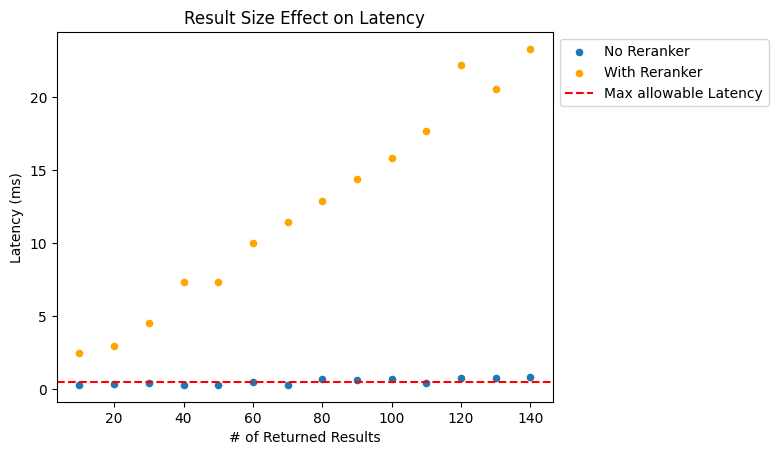

In [33]:
import time
import pandas as pd

def time_search(client: WeaviateWCS,
                collection_name: str,
                limit: int,
                rerank: bool
                ) -> float:
    '''
    Executes search given a limit value.
    Returns total time in seconds
    '''
    query = 'What is the best long term strategy for fat loss'
    start = time.perf_counter()
    response = client.hybrid_search(query, collection_name, limit=limit, return_properties=['content', 'title'])
    if rerank:
        reranked = reranker.rerank(response, query)
    end = time.perf_counter() - start
    return round(end, 3)

limit_values = list(range(10, 150, 10))

unranked_times = []
for n in tqdm(limit_values, 'Search: No Reranker'):
    unranked_times.append((time_search(client, collection_name, limit=n, rerank=False), n))


ranked_times = []
for n in tqdm(limit_values, 'Search: With Reranker'):
    ranked_times.append((time_search(client, collection_name, limit=n, rerank=True), n))



unranked = pd.DataFrame(unranked_times, columns=['time', 'n'])
ranked = pd.DataFrame(ranked_times, columns=['time', 'n'])

ax = unranked.plot.scatter(x='n', y='time', label='No Reranker', title='Result Size Effect on Latency')
ax2 = ranked.plot.scatter(x='n', y='time', ax=ax, color='orange', ylabel='Latency (ms)', label='With Reranker', xlabel='# of Returned Results')
hline = ax2.axhline(y = 0.5, color = 'r', linestyle = 'dashed', label = "Max allowable Latency")
legend = ax2.legend(bbox_to_anchor = (1.0, 1))

# Assignment 2.2 - New Retrieval Benchmark
***
**Reevaluate your retrieval results, this time using hybrid search and a Reranker**

#### Instructions:
- Fill in the areas of the code wherever you see a `None` statement.  Instantiate the `RetrievalEvaluationService` with an instance of your Weaviate retriever.  Then use the `execute_evaluation` method to run your retrieval benchmark.
- `execute_evaluation` is the same function from Notebook 3, albeit with some modifications to incorporate hybrid search and Reranker functionality.
- **Adjust the different hyperparameters to get the highest scoring retrieval score possible.**

In [45]:
from re import X
from src.evaluation.retrieval_evaluation import RetrievalEvaluationService
from src.preprocessor.preprocessing import FileIO

#################
##  START CODE ##
#################
from src.database.weaviate_interface_v4 import WeaviateWCS


data_path = 'data/golden_datasets/golden_256.json'



### Load QA dataset
golden_dataset = FileIO.load_json(data_path)
print(f'Total # of data: {len(golden_dataset)}')

### Instantiate Weaviate client and set Collection name
model_path = 'sentence-transformers/all-MiniLM-L6-v2'

### Instantiate Weaviate client and set Collection name
collection_name = client.show_all_collections()[0]
print(collection_name)

eval_service = RetrievalEvaluationService(client)
eval_results = eval_service.execute_evaluation(golden_dataset, collection_name, alpha=alpha_value, reranker=reranker)

#################
##  END CODE   ##
#################
print(eval_results)

Total # of data: 4

Huberman_minilmL6_256

Queries: 100%|██████████| 100/100 [1:21:25<00:00, 48.85s/it]
2024-12-19 04:25:13.268 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:457 - Total Evaluation Time: 81.42 minutes
2024-12-19 04:25:13.271 | INFO     | src.evaluation.retrieval_evaluation:execute_evaluation:461 - 'RetrievalEvaluationService' object has no attribute '_record_results'


RetrievalEvaluation(
    retrieve_limit=100,
    top_k=5,
    retriever='sentence-transformers/all-MiniLM-L6-v2',
    reranker='cross-encoder/ms-marco-MiniLM-L-6-v2',
    chunk_size=256,
    chunk_overlap=0,
    total_misses=14,
    total_questions=100,
    alpha=0.2,
    search_type='all',
    kw_raw_hits=78,
    kw_mrr=0.61,
    vector_raw_hits=83,
    vector_mrr=0.65,
    hybrid_raw_hits=83,
    hybrid_mrr=0.64,
    kw_hit_rate=0.78,
    vector_hit_rate=0.83,
    hybrid_hit_rate=0.83,
    evaluation_time='81.42 minutes'
)

### Retrieval Score improvement

At this point in the course you have several options at your disposal to improve your retrieval score to maximize the relevance of the context that you will feed the LLM for the Question Answering phase of the system.  I'll list your options here, from least to most complex:
- Use hybrid search
- Experiment with the `alpha` parameter to see which value works best for this dataset
- Use a ReRanker
- Push the boundary on your reranker by maxing out the `retrieve_limit` value.  Try to keep latency below 500 ms.  
- Swap out your embedding model for a more performant one
- Find a better reranker on the MTEB leaderboard
- Fine-tune your embedding model
- Fine-tune your embedding model on a larger dataset than the 300 samples in the `training_data_300.json`.  You have the ability to create your own dataset through OpenAI and the `generate_finetune_datasets` notebook.
- Change the BM25 tokenizer

# Conclusion
***

Feel free to submit your new benchmark retrieval scores to move up on the Class Leaderboard!  I hope this notebook provided you with a better understanding of how Hybrid Search and CrossEncoders work under the hood.  
You are now prepared to move on to integrating your (high quality) retrieval results into an LLM for answer synthesis.  We'll next take a look at how we can build context options for the LLM and engineer our prompt to stack the deck in our favor.   Onward!